In [2]:
act = 365

In [3]:
from re import I
import streamlit as st
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
import plotly.express as px
from scipy.optimize import minimize_scalar, minimize, LinearConstraint
import pickle
from scipy.stats import norm
import time
from numba import jit, njit
import matplotlib.pyplot as plt

In [4]:
# Generate a range of x values
x_values = np.linspace(-5, 5, 10000)  # Covers most of the Gaussian distribution
gaussian_cdf_values = norm.cdf(x_values)  # Compute the Gaussian CDF

# Store in a dictionary
gaussian_cdf_dict = np.vstack((x_values,gaussian_cdf_values))
# Save to a pickle file
with open("Data/gaussian_cdf.pkl", "wb") as f:
    pickle.dump(gaussian_cdf_dict, f)


@njit(parallel=True)
def retrieve_erf(x, my_pickle):
    """
    Retrieve the Gaussian CDF of x by finding the closest precomputed value in my_pickle.

    Parameters:
        x (float): The input value.
        my_pickle (dict): A dictionary containing precomputed Gaussian CDF values.

    Returns:
        float: The Gaussian CDF of x.
    """
    # Find the closest key in my_pickle
    x_values = my_pickle[0]
    cdf_values = my_pickle[1]
    closest_x_idx = np.argmin(np.abs(x_values - x))
    return cdf_values[closest_x_idx]

In [5]:
@jit
def prep_tba_values(
    SOFR_DATA, COUPON=2.5/100, OAS=102/100, VOL=102/100, 
    triangular_matrix=np.tri(30*12+1, 30*12+1).T, floor_quantity=0.5, 
    most_expensive_quantity=0.5, LOW_CPR=0.055, HIGH_CPR=0.42, MTG_MATURITY=30, 
    IS_MONTHLY=True, my_pickle=None):

    factor = 1
    if IS_MONTHLY:
        factor = 12
    LENGTH = MTG_MATURITY * factor + 1
    LENGTH_IDX = np.arange(LENGTH)

    # annuity
    annuity = 10000 * (1 - (1 + COUPON) ** -((MTG_MATURITY * factor - LENGTH_IDX) / factor)) / (1 - (1 + COUPON) ** (-MTG_MATURITY))

    # low CPR
    low_cpr = annuity * np.exp(-LOW_CPR / factor * LENGTH_IDX)

    # high CPR
    high_cpr = annuity * np.exp(-HIGH_CPR / factor * LENGTH_IDX)

    # CF bond
    x = np.ascontiguousarray(low_cpr)
    cf_bond = -np.diff(x) + COUPON * np.roll(low_cpr, 1)[1:] / factor

    # Notional (low - high)
    notional_diff = low_cpr - high_cpr

    # Rates + OAS
    rates_oas = (SOFR_DATA + OAS) / 100

    # ZC
    zero_coupon = (1+rates_oas)**(-LENGTH_IDX/factor)
    #zero_coupon = np.ones(LENGTH)
    #for i in range(1, LENGTH):
    #    zero_coupon[i] = zero_coupon[i - 1] / (1 + rates_oas[i] / factor)



    # DURATION
    duration = triangular_matrix @ (zero_coupon * notional_diff) / 10000 / factor

    # Forward SOFR
    fwd_sofr = triangular_matrix @ (rates_oas * zero_coupon * notional_diff) / duration / 10000 / factor

    # xSwaption
    x_swaption = (COUPON - fwd_sofr) / (VOL * np.sqrt(LENGTH_IDX / factor))
    
    # TODO comprendre  
    ERF_swpt = np.array([retrieve_erf(x, my_pickle) for x in x_swaption])
    density_swpt = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_swaption**2) / 2)

    # PSwaptions
    p_swaptions = duration * VOL * np.sqrt(LENGTH_IDX / factor) * (x_swaption * ERF_swpt + density_swpt) * 10000

    # xCap
    x_cap = (COUPON - rates_oas) / (VOL * np.sqrt(LENGTH_IDX / factor))
    
    ERF_cap = np.array([retrieve_erf(x, my_pickle) for x in x_cap])
    density_cap = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_cap**2) / 2)

    # Pcap
    p_cap = zero_coupon * VOL * np.sqrt(LENGTH_IDX / factor) * (x_cap * ERF_cap + density_cap) * notional_diff / factor

    return    (low_cpr, cf_bond, notional_diff, zero_coupon, duration, 
                ERF_swpt,p_swaptions, ERF_cap, p_cap)

@jit
def GENERATE_PRICER(
    SOFR_DATA, COUPON=2.5/100, OAS=102/100, VOL=102/100, 
    triangular_matrix=np.tri(30*12+1, 30*12+1).T, floor_quantity=0.5, 
    most_expensive_quantity=0.5, LOW_CPR=0.055, HIGH_CPR=0.42, MTG_MATURITY=30, 
    IS_MONTHLY=True, my_pickle=None):

    (low_cpr, cf_bond, notional_diff, zero_coupon, duration, 
    ERF_swpt,p_swaptions, ERF_cap, p_cap) = prep_tba_values(

        SOFR_DATA, COUPON, OAS, VOL, triangular_matrix, floor_quantity, 
        most_expensive_quantity, LOW_CPR, HIGH_CPR, MTG_MATURITY, 
        IS_MONTHLY, my_pickle
    )

    ret_max_spt = np.nanmax(p_swaptions)

    ret = (np.nansum((cf_bond * zero_coupon[1:])) - (most_expensive_quantity * ret_max_spt + floor_quantity * np.nansum(p_cap))) / 100

    return ret

@jit
def compute_delta(
    SOFR_DATA, COUPON=2.5/100, OAS=102/100, VOL=102/100, 
    triangular_matrix=np.tri(30*12+1, 30*12+1).T, floor_quantity=0.5, 
    most_expensive_quantity=0.5, LOW_CPR=0.055, HIGH_CPR=0.42, MTG_MATURITY=30, 
    IS_MONTHLY=True, my_pickle=None):

    factor = 1
    if IS_MONTHLY:
        factor = 12
    LENGTH = MTG_MATURITY * factor + 1
    LENGTH_IDX = np.arange(LENGTH)


    (low_cpr, cf_bond, notional_diff, zero_coupon, duration, 
    ERF_swpt,p_swaptions, ERF_cap, p_cap) = prep_tba_values(

                                    SOFR_DATA, COUPON, OAS, VOL, triangular_matrix, floor_quantity, 
                                    most_expensive_quantity, LOW_CPR, HIGH_CPR, MTG_MATURITY, 
                                    IS_MONTHLY, my_pickle
                                )

    # Delta Swaptions  
    delta_swaptions = (
                        duration * ERF_swpt + triangular_matrix @ (LENGTH_IDX * zero_coupon / factor) / factor / 10000 *
                        (p_swaptions/duration/factor)
                    )

    # Delta Cap
    delta_cap = zero_coupon*notional_diff/10000/factor*ERF_cap

    delta = ( floor_quantity*(np.nansum(delta_cap) + np.nansum(p_cap*LENGTH_IDX/factor/10000)) +
              most_expensive_quantity*delta_swaptions[np.argmax(p_swaptions[1:-1]) + 1]
            )
    
    bond_duration =( 
        np.nansum((low_cpr*zero_coupon)[1:])/10000/factor +
        np.nansum((zero_coupon*LENGTH_IDX/factor)[:-1])/duration[1] * 
        (np.nansum(cf_bond*zero_coupon[1:])/10000 - 1)*0.01
    )

    
    return bond_duration - delta


In [6]:
def GENERATE_PRICER_slow(
    SOFR_DATA, 
    COUPON=2.5/100, 
    OAS=102/100, 
    VOL=102/100, 
    floor_quantity=0.5, 
    most_expensive_quantity=0.5, 
    LOW_CPR=0.055, 
    HIGH_CPR=0.42, 
    MTG_MATURITY=30, 
    IS_MONTHLY=True, 
    my_pickle=None):

    factor = 1
    if IS_MONTHLY:
        factor = 12
    LENGTH = MTG_MATURITY * factor + 1
    LENGTH_IDX = np.arange(LENGTH)
    CPN = COUPON/factor
    N0 = 100

    # annuity
    annuity = N0 * (1 - (1 + CPN) ** -((MTG_MATURITY * factor - LENGTH_IDX))) / (1 - (1 + CPN) ** (-MTG_MATURITY*factor))
    # low CPR
    low_cpr = annuity * (1-LOW_CPR)**(LENGTH_IDX/factor)
    # high CPR
    #high_cpr = annuity * (1-HIGH_CPR)**(LENGTH_IDX/factor)
    high_cpr = low_cpr*(1-HIGH_CPR)/(1-LOW_CPR)
    # CF bond
    cf_bond = np.empty(LENGTH)
    cf_bond[0] = 0
    cf_bond[1:] = (low_cpr[:-1])*(1 + CPN) - low_cpr[1:]
    # Rates + OAS
    rates_oas = (SOFR_DATA + OAS) / 100
    # ZC
    ti_in_years = LENGTH_IDX*30/365
    zero_coupon = np.exp(-rates_oas*ti_in_years)

    bond_price = np.sum((cf_bond * zero_coupon))

    ##########
    ##########
    # options pricing
    # options Notional (low - high)
    notional_diff = low_cpr - high_cpr 
    # weights
    # w_j = B_j*N_{j-1}
    # w0 = 0
    weights = np.empty(LENGTH)
    weights[0] = 0
    weights[1:] = zero_coupon[1:]*low_cpr[:-1]

    # lvl_i =  1/(12*B_i*N_i) sum_{j=i+1}^{n} w_j 
    duration = np.cumsum(weights[::-1])[::-1]
    duration = np.roll(duration, -1)
    duration[:-1] = duration[:-1]/(zero_coupon*low_cpr*factor)[:-1]
    duration[-1] = 0

    # Swap rate
    # R_j = 12*(\frac{B_{j-1}}{B_j} - 1) j>=1
    #R0 = 0
    fwd_rates = np.empty(LENGTH)
    fwd_rates[0] = 0
    fwd_rates[1:] = (zero_coupon[:-1]/zero_coupon[1:] - 1)*factor
    weighted_fwd_rates = weights*fwd_rates

    # Si = sum(wj Rj)/ sum(wj) ; i+1<=j<=n
    swap_rate = np.cumsum(weighted_fwd_rates[::-1])[::-1]
    swap_rate = np.roll(swap_rate, -1)
    swap_rate[:-1] = swap_rate[:-1]/(duration*(zero_coupon*low_cpr*factor))[:-1]
    swap_rate[-1] = 0


    # swaption 1<=i<n
    # xSwaption
    x_swaption = (COUPON - swap_rate)[1:-1] / (VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]
    ERF_swpt =  np.array([retrieve_erf(x, my_pickle) for x in x_swaption])
    density_swpt = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_swaption**2) / 2)

    # PSwaptions
    p_swaptions = (duration * VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]*(x_swaption * ERF_swpt + density_swpt)
    p_swaptions = notional_diff[1:-1]*zero_coupon[1:-1]*p_swaptions
    ret_max_spt = np.nanmax(p_swaptions)

    # xCap
    x_cap = (COUPON - fwd_rates)[1:-1] / (VOL * np.sqrt(LENGTH_IDX / factor))[1:-1]
    ERF_cap = np.array([retrieve_erf(x, my_pickle) for x in x_cap])
    density_cap = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_cap**2) / 2)

    # Pcap
    p_cap = (zero_coupon * VOL * np.sqrt(LENGTH_IDX / factor))[1:-1] * (x_cap * ERF_cap + density_cap) * notional_diff[1:-1] / factor
    caplet_sum = np.nansum(p_cap)

    return bond_price -(most_expensive_quantity * ret_max_spt + floor_quantity * caplet_sum)


@njit
def GENERATE_PRICER_njit(
    SOFR_DATA, 
    COUPON=2.5/100, 
    OAS=102/100, 
    VOL=102/100, 
    floor_quantity=0.5, 
    most_expensive_quantity=0.5, 
    LOW_CPR=0.055, 
    HIGH_CPR=0.42, 
    MTG_MATURITY=30, 
    IS_MONTHLY=True, 
    my_pickle=None):

    factor = 1
    if IS_MONTHLY:
        factor = 12
    LENGTH = MTG_MATURITY * factor + 1
    LENGTH_IDX = np.arange(LENGTH)
    CPN = COUPON/factor
    N0 = 100

    # annuity
    annuity = N0 * (1 - (1 + CPN) ** -((MTG_MATURITY * factor - LENGTH_IDX))) / (1 - (1 + CPN) ** (-MTG_MATURITY*factor))
    # low CPR
    low_cpr = annuity * (1-LOW_CPR)**(LENGTH_IDX/factor)
    # high CPR
    #high_cpr = annuity * (1-HIGH_CPR)**(LENGTH_IDX/factor)
    high_cpr = low_cpr*(1-HIGH_CPR)/(1-LOW_CPR)
    # CF bond
    cf_bond = np.empty(LENGTH)
    cf_bond[0] = 0
    cf_bond[1:] = (low_cpr[:-1])*(1 + CPN) - low_cpr[1:]
    # Rates + OAS
    rates_oas = (SOFR_DATA + OAS) / 100
    # ZC
    ti_in_years = LENGTH_IDX*30/365
    zero_coupon = np.exp(-rates_oas*ti_in_years)

    bond_price = np.sum((cf_bond * zero_coupon))

    ##########
    ##########
    # options pricing
    # options Notional (low - high)
    notional_diff = low_cpr - high_cpr 
    # weights
    # w_j = B_j*N_{j-1}
    # w0 = 0
    weights = np.empty(LENGTH)
    weights[0] = 0
    weights[1:] = zero_coupon[1:]*low_cpr[:-1]

    # lvl_i =  1/(12*B_i*N_i) sum_{j=i+1}^{n} w_j 
    duration = np.cumsum(weights[::-1])[::-1]
    duration = np.roll(duration, -1)
    duration[:-1] = duration[:-1]/(zero_coupon*low_cpr*factor)[:-1]
    duration[-1] = 0

    # Swap rate
    # R_j = 12*(\frac{B_{j-1}}{B_j} - 1) j>=1
    #R0 = 0
    fwd_rates = np.empty(LENGTH)
    fwd_rates[0] = 0
    fwd_rates[1:] = (zero_coupon[:-1]/zero_coupon[1:] - 1)*factor
    weighted_fwd_rates = weights*fwd_rates

    # Si = sum(wj Rj)/ sum(wj) ; i+1<=j<=n
    swap_rate = np.cumsum(weighted_fwd_rates[::-1])[::-1]
    swap_rate = np.roll(swap_rate, -1)
    swap_rate[:-1] = swap_rate[:-1]/(duration*(zero_coupon*low_cpr*factor))[:-1]
    swap_rate[-1] = 0


    # swaption 1<=i<n
    # xSwaption
    x_swaption = (COUPON - swap_rate)[1:-1] / (VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]
    ERF_swpt =  np.array([retrieve_erf(x, my_pickle) for x in x_swaption])
    density_swpt = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_swaption**2) / 2)

    # PSwaptions
    p_swaptions = (duration * VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]*(x_swaption * ERF_swpt + density_swpt)
    p_swaptions = notional_diff[1:-1]*zero_coupon[1:-1]*p_swaptions
    ret_max_spt = np.nanmax(p_swaptions)

    # xCap
    x_cap = (COUPON - fwd_rates)[1:-1] / (VOL * np.sqrt(LENGTH_IDX / factor))[1:-1]
    ERF_cap = np.array([retrieve_erf(x, my_pickle) for x in x_cap])
    density_cap = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_cap**2) / 2)

    # Pcap
    p_cap = (zero_coupon * VOL * np.sqrt(LENGTH_IDX / factor))[1:-1] * (x_cap * ERF_cap + density_cap) * notional_diff[1:-1] / factor
    caplet_sum = np.nansum(p_cap)

    return bond_price -(most_expensive_quantity * ret_max_spt + floor_quantity * caplet_sum)



@jit
def GENERATE_PRICER_jit(
    SOFR_DATA, 
    COUPON=2.5/100, 
    OAS=102/100, 
    VOL=102/100, 
    floor_quantity=0.5, 
    most_expensive_quantity=0.5, 
    LOW_CPR=0.055, 
    HIGH_CPR=0.42, 
    MTG_MATURITY=30, 
    IS_MONTHLY=True, 
    my_pickle=None):

    factor = 1
    if IS_MONTHLY:
        factor = 12
    LENGTH = MTG_MATURITY * factor + 1
    LENGTH_IDX = np.arange(LENGTH)
    CPN = COUPON/factor
    N0 = 100

    # annuity
    annuity = N0 * (1 - (1 + CPN) ** -((MTG_MATURITY * factor - LENGTH_IDX))) / (1 - (1 + CPN) ** (-MTG_MATURITY*factor))
    # low CPR
    low_cpr = annuity * (1-LOW_CPR)**(LENGTH_IDX/factor)
    # high CPR
    #high_cpr = annuity * (1-HIGH_CPR)**(LENGTH_IDX/factor)
    high_cpr = low_cpr*(1-HIGH_CPR)/(1-LOW_CPR)
    # CF bond
    cf_bond = np.empty(LENGTH)
    cf_bond[0] = 0
    cf_bond[1:] = (low_cpr[:-1])*(1 + CPN) - low_cpr[1:]
    # Rates + OAS
    rates_oas = (SOFR_DATA + OAS) / 100
    # ZC
    ti_in_years = LENGTH_IDX*30/365
    zero_coupon = np.exp(-rates_oas*ti_in_years)

    bond_price = np.sum((cf_bond * zero_coupon))

    ##########
    ##########
    # options pricing
    # options Notional (low - high)
    notional_diff = low_cpr - high_cpr 
    # weights
    # w_j = B_j*N_{j-1}
    # w0 = 0
    weights = np.empty(LENGTH)
    weights[0] = 0
    weights[1:] = zero_coupon[1:]*low_cpr[:-1]

    # lvl_i =  1/(12*B_i*N_i) sum_{j=i+1}^{n} w_j 
    duration = np.cumsum(weights[::-1])[::-1]
    duration = np.roll(duration, -1)
    duration[:-1] = duration[:-1]/(zero_coupon*low_cpr*factor)[:-1]
    duration[-1] = 0

    # Swap rate
    # R_j = 12*(\frac{B_{j-1}}{B_j} - 1) j>=1
    #R0 = 0
    fwd_rates = np.empty(LENGTH)
    fwd_rates[0] = 0
    fwd_rates[1:] = (zero_coupon[:-1]/zero_coupon[1:] - 1)*factor
    weighted_fwd_rates = weights*fwd_rates

    # Si = sum(wj Rj)/ sum(wj) ; i+1<=j<=n
    swap_rate = np.cumsum(weighted_fwd_rates[::-1])[::-1]
    swap_rate = np.roll(swap_rate, -1)
    swap_rate[:-1] = swap_rate[:-1]/(duration*(zero_coupon*low_cpr*factor))[:-1]
    swap_rate[-1] = 0


    # swaption 1<=i<n
    # xSwaption
    x_swaption = (COUPON - swap_rate)[1:-1] / (VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]
    ERF_swpt =  np.array([retrieve_erf(x, my_pickle) for x in x_swaption])
    density_swpt = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_swaption**2) / 2)

    # PSwaptions
    p_swaptions = (duration * VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]*(x_swaption * ERF_swpt + density_swpt)
    p_swaptions = notional_diff[1:-1]*zero_coupon[1:-1]*p_swaptions
    ret_max_spt = np.nanmax(p_swaptions)

    # xCap
    x_cap = (COUPON - fwd_rates)[1:-1] / (VOL * np.sqrt(LENGTH_IDX / factor))[1:-1]
    ERF_cap = np.array([retrieve_erf(x, my_pickle) for x in x_cap])
    density_cap = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_cap**2) / 2)

    # Pcap
    p_cap = (zero_coupon * VOL * np.sqrt(LENGTH_IDX / factor))[1:-1] * (x_cap * ERF_cap + density_cap) * notional_diff[1:-1] / factor
    caplet_sum = np.nansum(p_cap)

    return bond_price -(most_expensive_quantity * ret_max_spt + floor_quantity * caplet_sum)

## params

In [7]:
DSCT_DATA = pd.read_csv("Data/rates.csv", index_col=0).dropna(how="all") * 100
DSCT_DATA.index = pd.to_datetime(DSCT_DATA.index, format="%Y-%m-%d")
DSCT_DATA.dropna(how='all', inplace=True)
Rates_monthly_data = DSCT_DATA.iloc[:, np.arange(1,30 * 12 + 1)*30 - 1].copy()
Rates_monthly_data['0'] = 0
Rates_monthly_data = Rates_monthly_data.loc[:, ['0'] + list(Rates_monthly_data.columns[:-1])]
Rates_monthly_data.to_csv('Data/rates_monthly.csv')

In [9]:
### GLOBAL VARIABLES ###
MTG_MAT = 30
MONTHLY = True
factor = 1
if MONTHLY:
    factor *= 12

TRIANG = np.tri(MTG_MAT*factor+1, MTG_MAT*factor+1).T
ALL_CPNS = np.arange(2.5, 7.0, 0.5)
ALL_CPNS_TBAS = np.arange(1.5, 8.0, 0.5)


OAS_DATA = pd.read_csv("Data/OAS_vs_TREAS.csv", index_col=0)
OAS_DATA.index = pd.to_datetime(OAS_DATA.index, format="%Y-%m-%d")
OAS_DATA = OAS_DATA.iloc[:, :9]
OAS_DATA.columns = ALL_CPNS
OAS_DATA.dropna(how='all', inplace=True)

TBAS_PRICES = pd.read_csv("Data/GENERIC_TBAS.csv", index_col=0).dropna(how="all")
TBAS_PRICES.index = pd.to_datetime(TBAS_PRICES.index, format="%Y-%m-%d")
TBAS_PRICES.columns = ALL_CPNS_TBAS
TBAS_PRICES.dropna(how='all', inplace=True)

IMPLIED_VOL_DATA = pd.read_csv("Data/implied_vol.csv", index_col=0).dropna(how="all")
IMPLIED_VOL_DATA.index = pd.to_datetime(IMPLIED_VOL_DATA.index, format="%Y-%m-%d")
IMPLIED_VOL_DATA = IMPLIED_VOL_DATA['3M10Y'].dropna()
IMPLIED_VOL_DATA = IMPLIED_VOL_DATA.apply(lambda x: float(x.replace(',', '.'))).sort_index()
IMPLIED_VOL_DATA.dropna(how='all', inplace=True)
implied_usd = IMPLIED_VOL_DATA


MTG = pd.read_csv('Data/MTG_RATE.csv', index_col=0)
MTG.index = pd.to_datetime(MTG.index, format="%m/%d/%y")
MTG = MTG[['Mortgage Rate']]
MTG.dropna(how='all', inplace=True)

LOAN_AGE = pd.read_csv('Data/loan_age.csv', index_col=0)
LOAN_AGE.index = pd.to_datetime(LOAN_AGE.index, format="%m/%d/%y")
LOAN_AGE = LOAN_AGE[[str(c) for c in ALL_CPNS]]
LOAN_AGE.columns = ALL_CPNS
LOAN_AGE.dropna(how='all', inplace=True)

In [18]:
for i, val in enumerate(ALL_CPNS):
    MTG[val] = val - MTG["Mortgage Rate"]

<AxesSubplot:xlabel='Dates'>

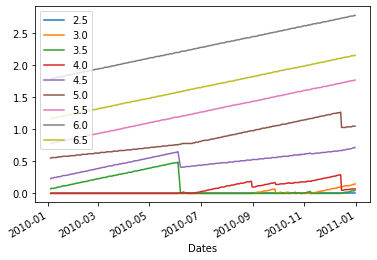

In [30]:
LOAN_AGE[ALL_CPNS].loc[:pd.to_datetime('01/01/2011')].plot()

<AxesSubplot:xlabel='Dates'>

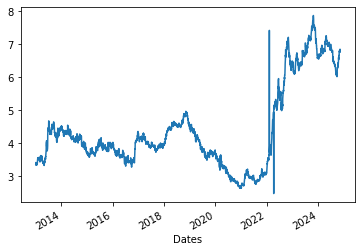

In [33]:
MTG['Mortgage Rate'].plot()

In [ ]:
dates = [ d for d in DSCT_DATA.index if 
        (
            d in IMPLIED_VOL_DATA.index and 
            d in TBAS_PRICES.index and 
            d in MTG.index and 
            d in LOAN_AGE.index
        )]

DSCT_DATA         = DSCT_DATA         .loc[dates]
IMPLIED_VOL_DATA  = IMPLIED_VOL_DATA  .loc[dates]
TBAS_PRICES       = TBAS_PRICES       .loc[dates] 
MTG               = MTG               .loc[dates] 
LOAN_AGE          = LOAN_AGE          .loc[dates]


with open("Data/gaussian_cdf.pkl", "rb") as f:
    pkl = pickle.load(f)

In [34]:
simple = True

Bmin_low = 6.0/100
Bmin_high =  8.0/100
Spread_low = 40.0/100

Spread_high = 55/100
alpha = 1.25
beta = 1.1/100
GAM = 5.0/100
shift = 0 / 100

low_cpr_param = 5/100
high_cpr_param = 30/100

BidOf = 1
LISSAGE = 10


for i, val in enumerate(ALL_CPNS):
    MTG[val] = val - MTG["Mortgage Rate"] - shift

## oas

In [36]:
rates_array = DSCT_DATA.to_numpy()
vol_array = IMPLIED_VOL_DATA.to_numpy()

loan_age_array = LOAN_AGE[ALL_CPNS].to_numpy()
mtg_array = MTG[ALL_CPNS].to_numpy()
tba_price_array = TBAS_PRICES[ALL_CPNS].to_numpy()
n_dates = len(dates)
n_cpn = len(ALL_CPNS) 

In [8]:
GENERATE_PRICER = GENERATE_PRICER_njit

In [11]:
@njit(parallel=True)

def run_oas(start=0, end=365) : 
        
    date_idx = start
    TO_FILL = np.zeros((n_dates, n_cpn))
    DELTA = np.zeros((n_dates, n_cpn))

    for _ in range(date_idx, end):

        if date_idx%30 == 0 : 
            print(date_idx/30)
        ref_data = rates_array[date_idx]
        ref_data = ref_data[np.arange(30 * 12 + 1)*30]

        VOL = vol_array[date_idx]

        col_idx = 0
        for c in ALL_CPNS:

            if not simple :
                loan_age_t = loan_age_array[date_idx, col_idx]
                phi = (1 - max(loan_age_t, 2) / MTG_MAT)* np.exp(-GAM * max(loan_age_t, 2))
                low_cpr = Bmin_low + (Bmin_high - Bmin_low) / (1 + np.exp(-alpha * (mtg_array[date_idx, col_idx])))
                high_cpr = Spread_low + (Spread_high - Spread_low) / (1 + np.exp(-beta * (mtg_array[date_idx, col_idx])))
                high_cpr = high_cpr * phi + low_cpr

            else : 
                low_cpr = low_cpr_param
                high_cpr = high_cpr_param

            tba = tba_price_array[date_idx, col_idx]

            
#            def f(x):
#
#                th_price = GENERATE_PRICER(
#                        ref_data, c/100, x/100, VOL/10000,
#                        LOW_CPR=low_cpr, HIGH_CPR=high_cpr,
#                        IS_MONTHLY=True, my_pickle=pkl)
#                
#                ret = abs(th_price - tba)
#                return ret
#
#            res = minimize_scalar(f, bounds=(-500, 500), method="bounded", options={'xatol': 1e-4})
            x = 0
            max_iter=100
            tol = 1e-5
            h = 1
            for _ in range(max_iter):               
                fx = GENERATE_PRICER(
                        ref_data, c/100, x/100, VOL/10000,
                        LOW_CPR=low_cpr, HIGH_CPR=high_cpr,
                        IS_MONTHLY=True, my_pickle=pkl) - tba
                
                f1x = GENERATE_PRICER(
                        ref_data, c/100, (x+h)/100, VOL/10000,
                        LOW_CPR=low_cpr, HIGH_CPR=high_cpr,
                        IS_MONTHLY=True, my_pickle=pkl) - tba                

                df_x = (f1x - fx) / h  # Numerical derivative approximation
                if abs(fx) < tol:  # Stop if value is zero
                    break
                x -= fx / df_x  # Newton's update step
            
            #print(x)
            TO_FILL[date_idx, col_idx] = x
        
            #delta = compute_delta(
            #        ref_data, c/100, res.x/100, VOL/10000, TRIANG,
            #        LOW_CPR=low_cpr, HIGH_CPR=high_cpr,
            #        IS_MONTHLY=True, my_pickle=pkl)

            #DELTA[date_idx, col_idx] = delta

            delta = GENERATE_PRICER(
                        ref_data, c/100, (x+1)/100, VOL/10000,
                        LOW_CPR=low_cpr, HIGH_CPR=high_cpr,
                        IS_MONTHLY=True, my_pickle=pkl) - tba
            DELTA[date_idx, col_idx] = delta

            col_idx += 1

        date_idx += 1
    return TO_FILL, DELTA


In [12]:
TO_FILL, DELTA = run_oas()

0.0
1.0
2.0
3.0
4.0
5.0


: 

In [98]:
OAS_computed = pd.DataFrame(TO_FILL, columns=ALL_CPNS, index=dates)
OAS_computed

,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-11-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
file_extension = f'_1'
OAS_computed = pd.DataFrame(TO_FILL, columns=ALL_CPNS, index=dates)
OAS_computed.to_csv(f"Data/OAS_computed{file_extension}.csv")

#### EXPORTING GREEKS ####
DELTA = pd.DataFrame(DELTA, columns=ALL_CPNS, index=dates)
DELTA.to_csv(f"Data/Durations_computed{file_extension}.csv")

## durations 

In [ ]:
Durations = np.zeros((len(dates), len(ALL_CPNS)))
idx_idx = 0

for ref_date in tqdm(dates[idx_idx:]):
    t1 = time.time()

    t1_1 = time.time()

    ref_data = DSCT_DATA.loc[ref_date]

    ref_data.index = ref_data.index.astype(int)
    ref_data.loc[0] = ref_data.loc[1]

    ref_data.index = ref_data.index / 30

    ref_data = ref_data.loc[np.arange(30 * 12 + 1)].to_numpy()

    closest_date_index = np.argmin(abs(ref_date - LOAN_AGE.index))
    VOL = IMPLIED_VOL_DATA.loc[ref_date]

    t2_1 = time.time()

    idx_col = 0
    for c in ALL_CPNS:
        t1_1 = time.time()
        loan_age_t = LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], c]
        phi = (1 - max(loan_age_t, 2) / MTG_MAT)* np.exp(-GAM * max(loan_age_t, 2))

        if np.isnan(phi):
            closest_nonna_cpn = LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], :].dropna().index[
                np.argmin(np.array(abs(c - LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], :].dropna().index)))]
            
            loan_age_t = LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], closest_nonna_cpn]
            phi = (1 - max(loan_age_t, 2) / MTG_MAT)* np.exp(-GAM * max(loan_age_t, 2))



        low_cpr = Bmin_low + (Bmin_high - Bmin_low) / (1 + np.exp(-alpha * (MTG.loc[MTG.index[closest_date_index], str(c)])))
        # low_cpr = low_cpr * phi + Bburnout * (1 - phi)
        high_cpr = Spread_low + (Spread_high - Spread_low) / (1 + np.exp(-beta * (MTG.loc[MTG.index[closest_date_index], str(c)])))
        high_cpr = high_cpr * phi
        t2_1 = time.time()
        oas = TO_FILL[idx_idx, idx_col]
        pv1bp = GENERATE_PRICER(ref_data + 0.01, c/100, oas/100, VOL/10000, TRIANG, LOW_CPR=low_cpr,
                                        HIGH_CPR=low_cpr + high_cpr,
                                        IS_MONTHLY=True, my_pickle=pkl)
        tba = TBAS_PRICES.loc[ref_date, c]
        dur = (tba - pv1bp)*100
        Durations[idx_idx, idx_col] = dur
        idx_col += 1

    idx_idx += 1

    Durations_computed = pd.DataFrame(Durations, columns=ALL_CPNS, index=dates)
    Durations_computed.to_csv(f"Data/Durations_computed_samy.csv")

    #### EXPORTING GREEKS ####
    #DELTA = pd.DataFrame.from_dict(all_delta)
    #DELTA.to_excel(f"{FILE_PATH}\\DELTA{agency_ext}.xlsx")

    #GAMMA = pd.DataFrame.from_dict(all_gamma)
    #GAMMA.to_excel(f"{FILE_PATH}\\GAMMA{agency_ext}.xlsx")

    #VEGA = pd.DataFrame.from_dict(all_vega)
    #VEGA.to_excel(f"{FILE_PATH}\\VEGA{agency_ext}.xlsx")

    #THETA = pd.DataFrame.from_dict(all_theta)
    #THETA.to_excel(f"{FILE_PATH}\\THETA{agency_ext}.xlsx")

    #MBS_DURATION = pd.DataFrame.from_dict(all_mbsduration)
    #MBS_DURATION.to_excel(f"{FILE_PATH}\\MBS_DURATION{agency_ext}.xlsx")


  0%|          | 0/2967 [00:00<?, ?it/s]

100%|██████████| 2967/2967 [09:20<00:00,  5.30it/s]


In [ ]:
Durations = np.zeros((len(dates), len(ALL_CPNS)))

OAS_COMPUTED = pd.read_csv(f'Data/OAS_computed.csv', index_col=0, parse_dates=True, dayfirst=False)
OAS_ARRAY = OAS_COMPUTED.to_numpy()
idx_idx = 0

for ref_date in tqdm(dates[idx_idx:]):
    t1 = time.time()

    t1_1 = time.time()

    ref_data = DSCT_DATA.loc[ref_date]

    ref_data.index = ref_data.index.astype(int)
    ref_data.loc[0] = ref_data.loc[1]

    ref_data.index = ref_data.index / 30

    ref_data = ref_data.loc[np.arange(30 * 12 + 1)].to_numpy()

    closest_date_index = np.argmin(abs(ref_date - LOAN_AGE.index))
    VOL = IMPLIED_VOL_DATA.loc[ref_date]

    t2_1 = time.time()

    idx_col = 0
    for c in ALL_CPNS:
        t1_1 = time.time()
        loan_age_t = LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], c]
        phi = (1 - max(loan_age_t, 2) / MTG_MAT)* np.exp(-GAM * max(loan_age_t, 2))

        if np.isnan(phi):
            closest_nonna_cpn = LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], :].dropna().index[
                np.argmin(np.array(abs(c - LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], :].dropna().index)))]
            
            loan_age_t = LOAN_AGE.loc[LOAN_AGE.index[closest_date_index], closest_nonna_cpn]
            phi = (1 - max(loan_age_t, 2) / MTG_MAT)* np.exp(-GAM * max(loan_age_t, 2))



        low_cpr = Bmin_low + (Bmin_high - Bmin_low) / (1 + np.exp(-alpha * (MTG.loc[MTG.index[closest_date_index], str(c)])))
        # low_cpr = low_cpr * phi + Bburnout * (1 - phi)
        high_cpr = Spread_low + (Spread_high - Spread_low) / (1 + np.exp(-beta * (MTG.loc[MTG.index[closest_date_index], str(c)])))
        high_cpr = high_cpr * phi
        t2_1 = time.time()
        oas = OAS_ARRAY[idx_idx, idx_col]
        if np.isnan(oas) :
            oas = 0
        dur = compute_delta(ref_data, c/100, oas/100, VOL/10000, TRIANG, LOW_CPR=low_cpr,
                                        HIGH_CPR=low_cpr + high_cpr,
                                        IS_MONTHLY=True, my_pickle=pkl)
       
        Durations[idx_idx, idx_col] = dur
        idx_col += 1

    idx_idx += 1

    Durations_computed = pd.DataFrame(Durations, columns=ALL_CPNS, index=dates)
    Durations_computed.to_csv(f"Data/Durations_computed_closed_formula.csv")

    #### EXPORTING GREEKS ####
    #DELTA = pd.DataFrame.from_dict(all_delta)
    #DELTA.to_excel(f"{FILE_PATH}\\DELTA{agency_ext}.xlsx")

    #GAMMA = pd.DataFrame.from_dict(all_gamma)
    #GAMMA.to_excel(f"{FILE_PATH}\\GAMMA{agency_ext}.xlsx")

    #VEGA = pd.DataFrame.from_dict(all_vega)
    #VEGA.to_excel(f"{FILE_PATH}\\VEGA{agency_ext}.xlsx")

    #THETA = pd.DataFrame.from_dict(all_theta)
    #THETA.to_excel(f"{FILE_PATH}\\THETA{agency_ext}.xlsx")

    #MBS_DURATION = pd.DataFrame.from_dict(all_mbsduration)
    #MBS_DURATION.to_excel(f"{FILE_PATH}\\MBS_DURATION{agency_ext}.xlsx")


  0%|          | 0/2967 [00:00<?, ?it/s]

100%|██████████| 2967/2967 [09:25<00:00,  5.25it/s]


## debug 

In [37]:
date_idx = 560
ref_date= dates[date_idx]
ref_date

Timestamp('2015-04-01 00:00:00')

In [38]:
date_idx

560

In [41]:
SOFR_DATA = rates_array[date_idx]
SOFR_DATA = SOFR_DATA[np.arange(30 * 12 + 1)*30]
VOL = vol_array[date_idx]/10000
col_idx = 2
COUPON = ALL_CPNS[2]/100
market_price = tba_price_array[date_idx, col_idx]

LOW_CPR = 0.05
HIGH_CPR = 0.35

OAS = 1/100
floor_quantity=0.5
most_expensive_quantity=0.5 
MTG_MATURITY=20
IS_MONTHLY=True
my_pickle= pkl

In [42]:
factor = 1
if IS_MONTHLY:
    factor = 12
LENGTH = MTG_MATURITY * factor + 1
LENGTH_IDX = np.arange(LENGTH)
CPN = COUPON/factor
N0 = 100

# annuity
annuity = N0 * (1 - (1 + CPN) ** -((MTG_MATURITY * factor - LENGTH_IDX))) / (1 - (1 + CPN) ** (-MTG_MATURITY*factor))
# low CPR
low_cpr = annuity * (1-LOW_CPR)**(LENGTH_IDX/factor)
# high CPR
#high_cpr = annuity * (1-HIGH_CPR)**(LENGTH_IDX/factor)
high_cpr = low_cpr*(1-HIGH_CPR)/(1-LOW_CPR)
# CF bond
cf_bond = np.empty(LENGTH)
cf_bond[0] = 0
cf_bond[1:] = (low_cpr[:-1])*(1 + CPN) - low_cpr[1:]
# Rates + OAS
rates_oas = (SOFR_DATA + OAS)[:LENGTH] / 100
# ZC
ti_in_years = LENGTH_IDX*30/365
zero_coupon = np.exp(-rates_oas*ti_in_years)
bond_price = np.sum((cf_bond * zero_coupon))
dbond_price = -np.sum((cf_bond * zero_coupon*ti_in_years))/N0

##########
##########
# options pricing
# options Notional (low - high)
notional_diff = low_cpr - high_cpr 
# weights
# w_j = B_j*N_{j-1}
# w0 = 0
weights = np.empty(LENGTH)
weights[0] = 0
weights[1:] = zero_coupon[1:]*low_cpr[:-1]

# lvl_i =  1/(12*B_i*N_i) sum_{j=i+1}^{n} w_j 
duration = np.cumsum(weights[::-1])[::-1]
duration = np.roll(duration, -1)
duration[:-1] = duration[:-1]/(zero_coupon*low_cpr*factor)[:-1]
duration[-1] = 0

# Swap rate
# R_j = 12*(\frac{B_{j-1}}{B_j} - 1) j>=1
#R0 = 0
fwd_rates = np.empty(LENGTH)
fwd_rates[0] = 0
fwd_rates[1:] = (zero_coupon[:-1]/zero_coupon[1:] - 1)*factor
weighted_fwd_rates = weights*fwd_rates

# Si = sum(wj Rj)/ sum(wj) ; i+1<=j<=n
swap_rate = np.cumsum(weighted_fwd_rates[::-1])[::-1]
swap_rate = np.roll(swap_rate, -1)
swap_rate[:-1] = swap_rate[:-1]/(duration*(zero_coupon*low_cpr*factor))[:-1]
swap_rate[-1] = 0


# swaption 1<=i<n
# xSwaption
x_swaption = (COUPON - swap_rate)[1:-1] / (VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]
ERF_swpt =  np.array([retrieve_erf(x, my_pickle) for x in x_swaption])
density_swpt = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_swaption**2) / 2)

# PSwaptions
p_swaptions = (duration * VOL * np.sqrt(LENGTH_IDX/factor))[1:-1]*(x_swaption * ERF_swpt + density_swpt)
p_swaptions = notional_diff[1:-1]*zero_coupon[1:-1]*p_swaptions
ret_max_spt = np.nanmax(p_swaptions)


notional_diff[1:-1]*duration[1:-1]*zero_coupon[1:-1]
# xCap
x_cap = (COUPON - fwd_rates)[1:-1] / (VOL * np.sqrt(LENGTH_IDX / factor))[1:-1]
ERF_cap = np.array([retrieve_erf(x, my_pickle) for x in x_cap])
density_cap = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_cap**2) / 2)

# Pcap
p_cap = (zero_coupon * VOL * np.sqrt(LENGTH_IDX / factor))[1:-1] * (x_cap * ERF_cap + density_cap) * notional_diff[1:-1] / factor
caplet_sum = np.nansum(p_cap)


result = bond_price -(most_expensive_quantity * ret_max_spt + floor_quantity * caplet_sum)

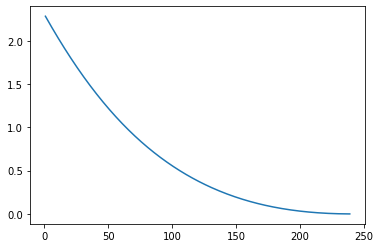

In [43]:
idx = np.argmax(p_swaptions)
swaptions_duration = notional_diff[1:-1]*duration[1:-1]*zero_coupon[1:-1]/N0
plt.plot(LENGTH_IDX[1:-1], swaptions_duration)